In [1]:
from scipy.integrate import odeint
from scipy.stats import lognorm
import numpy as np
from ode_api import *
from ode_funcs import *
import matplotlib.pyplot as plt
import scipy
import pymc3 as pm
import pprint

THEANO_FLAGS = 'exception_verbosity=high'
THEANO_FLAGS='optimizer=fast_compile'
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'

# Test 1: Vector ODE with 1 parameter

$$ S' = -\mathcal{R}_0 SI \quad S(0) = 0.99 $$
$$ I' = \mathcal{R}_0 SI - I \quad I(0) = 0.01 $$

In [2]:
#Specify how many stats, initial values, and ode parameters there are
n_states = 2
n_odeparams = 1

data = make_test_data_3()
#Times to evaluate the solution
times = data['t']

#Instantiate the ODEModel
ode_model = ODEModel(func = test_ode_func_3, 
                    t0 = 0,
                    times = times,
                    n_states = n_states,
                    n_odeparams = n_odeparams)

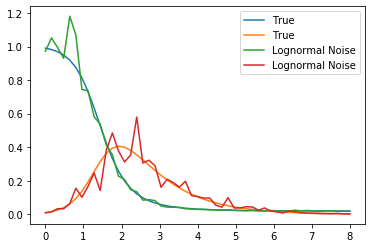

In [3]:
Ytrue = data['y']
Y = data['yobs']

plt.plot(times,Ytrue, label = 'True')
plt.plot(times,Y, label = 'Lognormal Noise')
plt.legend()



In [4]:

    
my_ODEop = ODEop(ode_model)


In [5]:
# The probabilistic model
with pm.Model() as first_model:

    # Priors for unknown model parameters
    R = pm.Bound(pm.Normal, lower=1)('R', mu = 1, sd = 2)

    sigma = pm.HalfCauchy('sigma',1, shape = 2)

    # Forward model
    #[ODE Parameters, initial condition]
    all_params = pm.math.stack([R,0.99, 0.01],axis=0)

    
    ode_sol = my_ODEop(all_params)

    
    forward = ode_sol.reshape(Y.shape)

    
    ode = pm.Deterministic('ode',ode_sol)
    
    

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)

    
    trace = pm.sample(2000, tune=1000, init='adapt_diag', target_accept = 0.99)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, R]
Sampling 4 chains: 100%|██████████| 12000/12000 [15:07<00:00,  8.74draws/s]


[0.1, 0.25]


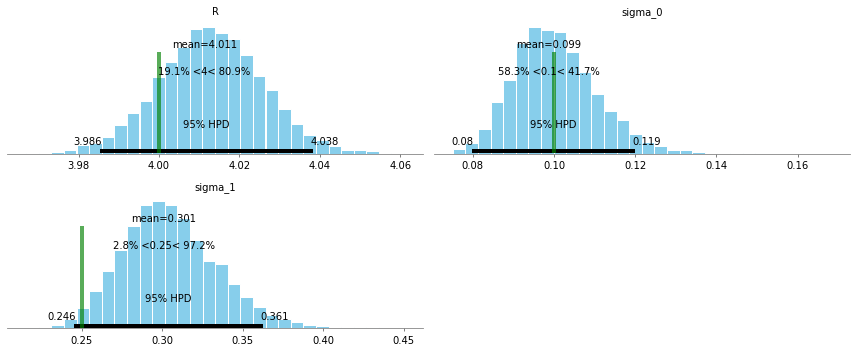

In [15]:

pm.posteriorplot.plot_posterior(trace, varnames=['R','sigma'], ref_val=[4, 0.1, 0.25]);

In [7]:
pprint.pprint(pm.gelman_rubin(trace))

pprint.pprint(pm.effective_n(trace))

{'R': 0.9998261374863183,
 'ode': array([0.99974997, 0.99974997, 0.99982619, 0.99982619, 0.99982623,
       0.99982624, 0.99982627, 0.99982628, 0.99982631, 0.99982631,
       0.99982632, 0.99982633, 0.99982632, 0.99982632, 0.99982629,
       0.99982628, 0.99982622, 0.9998262 , 0.99982613, 0.99982608,
       0.99982604, 0.99982592, 0.99982594, 0.99982573, 0.99982586,
       0.99982543, 0.9998258 , 0.99982466, 0.99982576, 0.99983535,
       0.99982573, 0.99982697, 0.99982571, 0.99982643, 0.9998257 ,
       0.99982623, 0.99982569, 0.99982612, 0.99982569, 0.99982605,
       0.99982569, 0.999826  , 0.9998257 , 0.99982597, 0.9998257 ,
       0.99982594, 0.99982571, 0.99982592, 0.99982571, 0.9998259 ,
       0.99982572, 0.99982588, 0.99982573, 0.99982587, 0.99982573,
       0.99982586, 0.99982574, 0.99982585, 0.99982574, 0.99982584,
       0.99982575, 0.99982583, 0.99982575, 0.99982582, 0.99982576,
       0.99982581, 0.99982576, 0.99982581, 0.99982576, 0.9998258 ,
       0.99982577, 0.9998258

In [8]:
with first_model:
    ppc = pm.sample_ppc(trace, 500)

100%|██████████| 500/500 [00:19<00:00, 25.69it/s]


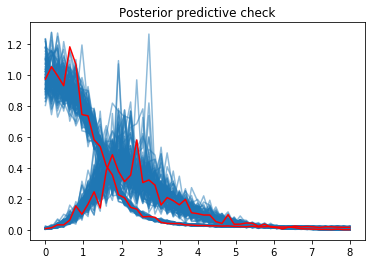

In [9]:
yobs = ppc['Y_obs']
for i in range(100):

    plt.plot(times, yobs[i], color = 'C0', alpha = 0.5)
    
plt.plot(times,Y, color = 'red')
plt.title('Posterior predictive check');

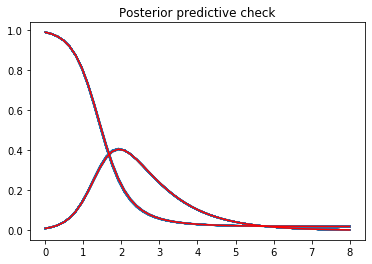

In [10]:
yobs = trace['ode']
for i in range(100):

    plt.plot(times, yobs[i].reshape(Y.shape), color = 'C0', alpha = 0.5)
    
plt.plot(times,Ytrue, color = 'red')
plt.title('Posterior predictive check');